## EqLock: Statistics of Earthquakes and Detector Lockloss

**Inputs:**
* Channels: choose frequency band and ETM/ITM channels of interest
* Parameters: (Section 1) start time of all data, duration of all data; (2) the required width of peaks, prominience of peaks, and horizontal distance between peaks; (3) interval before/after peak to find earthquake, maximum lock value; and (5) bins to plot probability.

**Outputs:**
* Statistics: date of peak, if earthquake event (peak) broke lock, time of peak, vertical ground velocity, horizontal ground velocity, ratio vert./horiz. velocity, time of lockloss, and the vertical and horizontal velocities at time of lockloss.
* Plots: vertical vs. horizontal ground velocities, probability of surviving an earthquake of certain magnitude

In [1]:
import pandas as pd
import numpy as np

from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag
from gwpy.time import tconvert, from_gps, to_gps
from astropy.time import Time
from scipy.signal import find_peaks
from datetime import date

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from numpy import sqrt
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
%matplotlib inline

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
start_time = Time('2023-05-24 00:00:00', format='iso', scale='utc')
end_time = Time('2023-09-01 00:00:00', format='iso', scale='utc')

In [3]:
#choose main seismic channel
#vertical + horizontal channels for end stations ETMX, ETMY and inner station ITMY
#first 3 are Z-channels, then X and Y for each station
channel = 'L1:ISI-GND_STS_'
channels = ['ETMX_Z', 'ETMY_Z', 'ITMY_Z', 'ETMX_X','ETMX_Y', 'ETMY_X', 'ETMY_Y', 'ITMY_X', 'ITMY_Y']
band = '_BLRMS_30M_100M.max' #earthquake band 0.03-0.1 Hz

#frametype for TimeSeries #L1_M is minute-trend
fr = 'L1_M'

#lock values channel
lockchannel = 'L1:GRD-ISC_LOCK_STATE_N.min'
lsegchannel = 'L1:DMT-GRD_ISC_LOCK_NOMINAL:1'

#choose folder location and name of csv data files
#keep location (L1 or H1), channel, date, and frequency in filename
Dir = 'L1/'
seisfname = Dir + 'L1_seis_may24sep01_30M_100M.csv'
lockfname = Dir + 'L1_lock_may24sep01.csv'
lsegfname = Dir + 'L1_lockseg_may24sep01.csv'

### Section 1: Get seismic and lockbit data
* Import the time series of the seismic motion (in the earthquake band) and lock data as minute trends, then the resulting dataframes are saved to CSV files.
* Note on efficiency: This is most time-consuming part of code!
    * For one month of data, it takes between 1.5-4.5 hours (typically ~3 hours) to get the seismic TimeSeries and 10-30 minutes to get lockbit TimeSeries data.
    * If importing large amounts of data, I recommend breaking it up and repeating Sections 1, 2, and 3. If separated by month, for example, Section 1 saves two csv files (seismic and lock data) for each month. Section 2 then loads the data from these csv files, and Section 3 gathers statistics for this time interval.

In [4]:
%%time
#time this cell to understand efficiency

#get timeseries in earthquake band ground motion
channelRMS = []
for chn in channels:
    chname = channel + chn + band
    data = TimeSeries.find(chname, start_time.gps, end_time.gps, frametype=fr, verbose=True) 
    channelRMS.append(data.value)

RuntimeError: Missing segments: 
[1373760018 ... 1377561618)

In [101]:
#store earthquake-band seismic data
seisdata = pd.DataFrame(np.transpose(channelRMS), columns = [channels])

In [102]:
#save to csv 
seisdata.to_csv(seisfname)

In [103]:
%%time
#find time series for lockbit data

lockstate = []
lock_ts = TimeSeries.find(lockchannel, start_time.gps, end_time.gps, frametype=fr, verbose=True) #minute-trend
lockstate.append(lock_ts.value)


Reading L1_M frames: |          | 0/1057 (  0%) ETA ?     
Reading L1_M frames: |          | 0/1057 (  0%) ETA ?     
Reading L1_M frames: |          | 1/1057 (  0%) ETA 30:12 
Reading L1_M frames: |          | 2/1057 (  0%) ETA 33:03 
Reading L1_M frames: |          | 3/1057 (  0%) ETA 31:51 
Reading L1_M frames: |          | 4/1057 (  0%) ETA 31:04 
Reading L1_M frames: |          | 5/1057 (  0%) ETA 32:46 
Reading L1_M frames: |          | 6/1057 (  1%) ETA 31:48 
Reading L1_M frames: |          | 7/1057 (  1%) ETA 31:10 
Reading L1_M frames: |          | 8/1057 (  1%) ETA 30:32 
Reading L1_M frames: |          | 9/1057 (  1%) ETA 30:24 
Reading L1_M frames: |          | 10/1057 (  1%) ETA 30:03 
Reading L1_M frames: |          | 11/1057 (  1%) ETA 30:59 
Reading L1_M frames: |          | 12/1057 (  1%) ETA 29:23 
Reading L1_M frames: |          | 13/1057 (  1%) ETA 30:24 
Reading L1_M frames: |▏         | 14/1057 (  1%) ETA 31:07 
Reading L1_M frames: |▏         | 15/1057 (  1%) E

In [104]:
#store lockbit data
lbdata = pd.DataFrame(np.transpose(lockstate)) 

In [105]:
#save to csv
lbdata.to_csv(lockfname) 

In [4]:
start_time = Time('2023-05-24 00:00:00', format='iso', scale='utc')
end_time = Time('2023-07-19 00:00:00', format='iso', scale='utc')
totlsegfname = Dir + 'L1_lockseg_may24jul19.csv'

In [337]:
%%time
#download lock segments
obseg = DataQualityFlag.query(lsegchannel, start_time, end_time).active

CPU times: user 169 ms, sys: 29.1 ms, total: 199 ms
Wall time: 5min 46s


In [338]:
obsdf = pd.DataFrame(np.transpose(obseg)) 
obsdf

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,1.368923e+09,1.368931e+09,1.368953e+09,1.368979e+09,1.369184e+09,1.369205e+09,1.369240e+09,1.369253e+09,1.369275e+09,1.369299e+09,...,1.373490e+09,1.373516e+09,1.373546e+09,1.373553e+09,1.373572e+09,1.373614e+09,1.373658e+09,1.373669e+09,1.373674e+09,1.373758e+09
1,1.368924e+09,1.368939e+09,1.368963e+09,1.368998e+09,1.369200e+09,1.369231e+09,1.369247e+09,1.369264e+09,1.369292e+09,1.369334e+09,...,1.373514e+09,1.373526e+09,1.373546e+09,1.373562e+09,1.373600e+09,1.373651e+09,1.373669e+09,1.373669e+09,1.373712e+09,1.373760e+09


In [339]:
obsdf.to_csv(lsegfname) 

### Section 2: Combine data & find earthquakes
* Three key parameters set here (width, prominence, and distance) define what is considered a peak in the data, thus what characterizes an earthquake. Use these parameters as arguments in the find_peaks command.
* If peaks are common to 2 or more of the 3 vertical channels, it is categorized as an earthquake. The earthquakes can then be plotted along with the seismic data.

In [11]:
#get seismic and lock dataframes from file
df = pd.read_csv('L1_eqlockdf_may24jul19_30M_100M.csv', index_col=[0])

In [14]:
df = df[df['Broke Lock']=='No']
df = df.sort_values(by=['Vert. Vel.'], ascending=False)
df

,Date,Broke Lock,Time of Peak,Vert. Vel.,Horiz. Vel.,Ratio V/H,Time of Lock Loss,LL Vert. Vel.,LL Horiz. Vel.
69,2023-07-10 00:59:00,No,1.372986e+09,482.084300,1506.932026,0.319911,-,-,-
56,2023-07-01 11:02:00,No,1.372245e+09,354.547150,741.162659,0.478366,-,-,-
32,2023-06-16 12:54:00,No,1.370955e+09,321.758450,653.026366,0.492719,-,-,-
7,2023-05-31 03:25:00,No,1.369539e+09,295.658780,963.506792,0.306857,-,-,-
66,2023-07-08 23:05:00,No,1.372893e+09,287.728000,663.070948,0.433932,-,-,-
20,2023-06-09 22:30:00,No,1.370385e+09,270.692400,480.215593,0.563689,-,-,-
45,2023-06-20 11:19:00,No,1.371295e+09,264.483280,531.966744,0.497180,-,-,-
50,2023-06-23 20:46:00,No,1.371588e+09,262.373500,616.652862,0.425480,-,-,-
35,2023-06-17 06:15:00,No,1.371018e+09,261.257800,576.653828,0.453058,-,-,-
21,2023-06-10 10:10:00,No,1.370427e+09,240.617650,512.414317,0.469576,-,-,-


In [17]:
sei = pd.concat(map(pd.read_csv, [Dir+'L1_seis_may24jul19_30M_100M.csv', Dir+'L1_seis_jul19sep01_30M_100M.csv']), ignore_index=True)
loc = pd.concat(map(pd.read_csv, [Dir+'L1_lock_may24jul19.csv', Dir+'L1_lock_jul19sep01.csv']), ignore_index=True)
lseg = pd.concat(map(pd.read_csv, [Dir+'L1_lockseg_may24jul19.csv', Dir+'L1_lockseg_jul19sep01.csv']), axis=1, ignore_index=True)

In [18]:
sei.to_csv(seisfname)
loc.to_csv(lockfname)
lseg.to_csv(lsegfname)

In [19]:
#get seismic and lock dataframes from file
seisdf = pd.read_csv(seisfname)
lockdf = pd.read_csv(lockfname)
lsegdf = pd.read_csv(lsegfname, index_col=[0])

In [22]:
lsegdf

,0,1,2,3,4,5,6,7,8,9,...,234,235,236,237,238,239,240,241,242,243
0,0,1.368922e+09,1.368928e+09,1.368928e+09,1.369014e+09,1.369036e+09,1.369140e+09,1.369180e+09,1.369451e+09,1.369511e+09,...,1.377308e+09,1.377360e+09,1.377363e+09,1.377371e+09,1.377372e+09,1.377377e+09,1.377452e+09,1.377478e+09,1.377534e+09,1.377561e+09
1,1,1.368928e+09,1.368928e+09,1.369014e+09,1.369019e+09,1.369134e+09,1.369177e+09,1.369447e+09,1.369491e+09,1.369512e+09,...,1.377360e+09,1.377363e+09,1.377364e+09,1.377372e+09,1.377377e+09,1.377444e+09,1.377473e+09,1.377532e+09,1.377557e+09,1.377562e+09


In [23]:
#set parameters to use with find_peaks command
peakwidth = 5 
peakprom = 50
peakdist = 120

In [24]:
peaksRMSix = []

#find location of local peaks in each Z-channel
#just first 3 channels because only want vertical motion
for i in channels[0:3]: 
    peaksix,_ = find_peaks(seisdf[i], width = peakwidth, distance = peakdist, prominence = peakprom)
    peaksRMSix.append(peaksix)

peaksRMSix

[array([   974,   1646,   1769,   3555,   4258,   5367,   8753,
          9686,  10285,  10841,  10976,  14542,  14927,  15141,
         15771,  17528,  18377,  18596,  19288,  20254,  21014,
         21299,  22223,  22877,  23771,  24390,  25090,  25987,
         26158,  26574,  26824,  27501,  29356,  29623,  29819,
         31379,  31960,  32854,  33325,  33740,  33894,  34400,
         34712,  34935,  35375,  35796,  35957,  36082,  36996,
         37309,  37480,  37687,  37847,  38050,  38247,  38714,
         39235,  39559,  39951,  40675,  43011,  44210,  44442,
         44605,  46268,  46632,  48405,  48557,  50628,  54276,
         55382,  56503,  56935,  57055,  59043,  59246,  59943,
         60178,  61392,  62092,  62334,  62742,  66034,  66185,
         66443,  67236,  67462,  67739,  69050,  72351,  72561,
         72960,  73599,  73777,  74147,  74571,  74827,  76584,
         76889,  77278,  77613,  78088,  78242,  79189,  79950,
         80224,  80856,  81000,  81291, 

In [25]:
#find common peaks in at least two of the three Z-channels, define those as earthquakes (EQs)
EQix = []

EQix.append(np.intersect1d(peaksRMSix[0],peaksRMSix[1]))
EQix.append(np.intersect1d(peaksRMSix[1],peaksRMSix[2]))
EQix.append(np.intersect1d(peaksRMSix[2],peaksRMSix[0]))

EQix = np.unique(np.concatenate(EQix))
EQix #returns location of each EQ peak in minutes from the start time

array([   974,   1646,   3555,   4257,   5367,   8753,   9686,
        10285,  10841,  14532,  14927,  15141,  17528,  17735,
        18378,  19288,  20254,  21299,  22223,  22877,  24390,
        25090,  26158,  26574,  26824,  27501,  29355,  29623,
        29819,  31960,  32855,  33740,  33894,  34400,  34712,
        34935,  35796,  36082,  36996,  37304,  37480,  37687,
        37847,  38050,  38249,  39559,  39951,  40675,  43011,
        44210,  44446,  44605,  46268,  46632,  48405,  54284,
        55382,  56503,  56935,  57055,  59043,  59244,  59943,
        62092,  62330,  62742,  66185,  66443,  67236,  67739,
        69049,  72351,  72561,  72960,  73741,  74147,  74571,
        74826,  76584,  76889,  77278,  77613,  78088,  78242,
        79950,  80856,  81000,  81291,  84901,  85794,  87265,
        87699,  88223,  89615,  89863,  91730,  92493,  92830,
        94347,  95029,  96078,  96749, 100598, 102533, 103634,
       104650, 105762, 106181, 106331, 106486, 107642, 

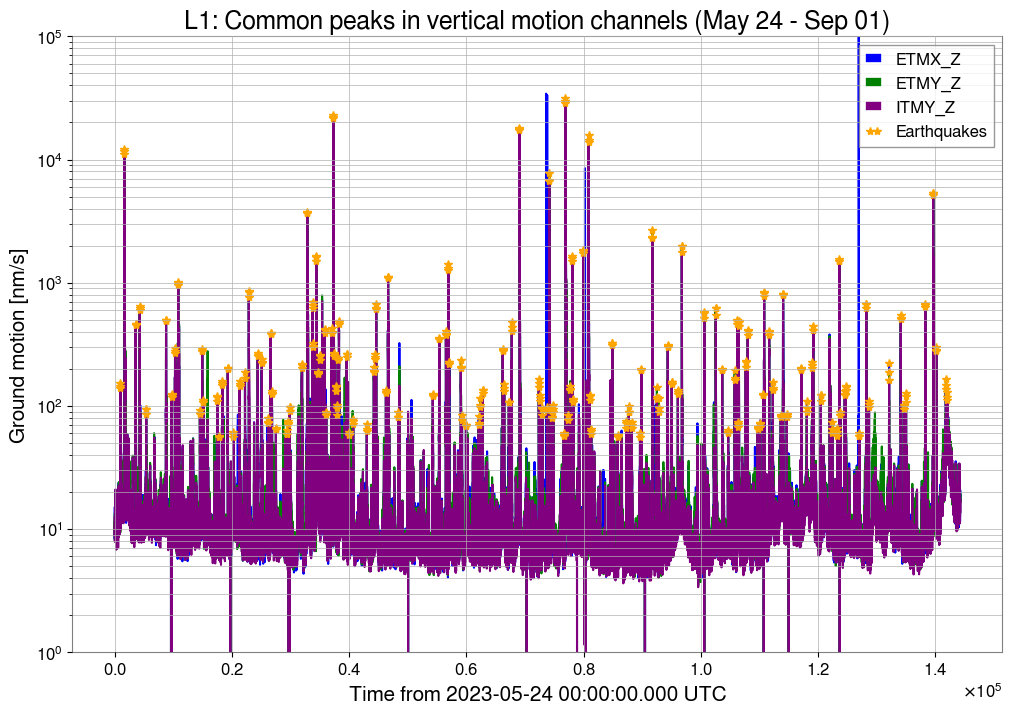

In [26]:
#plot common peaks in ETMX_Z, ETMY_Z, and ITMY_Z
plt.figure(figsize=(12,8))
plt.title('L1: Common peaks in vertical motion channels (May 24 - Sep 01)',fontsize=18)

#plot ground motion
colors = ['blue','green','purple']
for jj in range(3): #just first 3 channels, in this example
    plt.plot(seisdf[channels[jj]], color = colors[jj])

#plot earthquakes
for jj in range(3):
    for i in range(len(EQix)): #loop over common EQ peaks
        plt.plot(EQix[i], seisdf[channels[jj]][EQix[i]], '*', color = 'orange')

plt.grid(True, which="both")
plt.legend(['ETMX_Z', 'ETMY_Z', 'ITMY_Z', 'Earthquakes'])
#labels = ['05-24','05-31','06-07','06-14','06-21','06-28','07-05','07-12','07-19','07-26','08-02','08-09','08-16','08-23','08-30'] #labels for each week
#plt.xticks(np.arange(0, len(seisdf)+1, step=10080), labels)
plt.xlabel('Time from %s UTC' % start_time, fontsize=15)
plt.ylabel('Ground motion [nm/s]',fontsize=15)
plt.ylim(1, 10**5)
plt.yscale('log')
plt.show()

### Section 3: Get statistics
* Step through a chosen interval to find if and when the detector loses lock.
* The delta parameter refers to the time interval around a peak in seismic motion data, where the number represents the number of minutes either before or after the peak. The total time interval is therefore 2 x delta.
* The statistics found for each earthquake peak are the following: date of peak, yes/no if earthquake broke lock, time of peak, vertical ground velocity, horizontal ground velocity, ratio of vertical/horizontal velocities, and also for the earthquakes that did not survive, the time of lost lock, and the vertical and horizontal ground velocities at that time.

In [27]:
#will store final dataframe of earthquake statistics
eqfname = "L1_eqdf_may24sep01_30M_100M.csv" 

In [28]:
#GPS times of common peaks
EQix_secs = [element * 60 for element in EQix] #convert minutes to seconds
EQix_gps = [element + start_time.gps for element in EQix_secs]
print(len(EQix_gps))

144


In [29]:
for i in EQix_gps:
    print(from_gps(i))

2023-05-24 16:14:00
2023-05-25 03:26:00
2023-05-26 11:15:00
2023-05-26 22:57:00
2023-05-27 17:27:00
2023-05-30 01:53:00
2023-05-30 17:26:00
2023-05-31 03:25:00
2023-05-31 12:41:00
2023-06-03 02:12:00
2023-06-03 08:47:00
2023-06-03 12:21:00
2023-06-05 04:08:00
2023-06-05 07:35:00
2023-06-05 18:18:00
2023-06-06 09:28:00
2023-06-07 01:34:00
2023-06-07 18:59:00
2023-06-08 10:23:00
2023-06-08 21:17:00
2023-06-09 22:30:00
2023-06-10 10:10:00
2023-06-11 03:58:00
2023-06-11 10:54:00
2023-06-11 15:04:00
2023-06-12 02:21:00
2023-06-13 09:15:00
2023-06-13 13:43:00
2023-06-13 16:59:00
2023-06-15 04:40:00
2023-06-15 19:35:00
2023-06-16 10:20:00
2023-06-16 12:54:00
2023-06-16 21:20:00
2023-06-17 02:32:00
2023-06-17 06:15:00
2023-06-17 20:36:00
2023-06-18 01:22:00
2023-06-18 16:36:00
2023-06-18 21:44:00
2023-06-19 00:40:00
2023-06-19 04:07:00
2023-06-19 06:47:00
2023-06-19 10:10:00
2023-06-19 13:29:00
2023-06-20 11:19:00
2023-06-20 17:51:00
2023-06-21 05:55:00
2023-06-22 20:51:00
2023-06-23 16:50:00


In [30]:
for i in range(len(lsegdf.columns)):
    print(from_gps(lsegdf[str(i)][0]))

1980-01-06 00:00:00
2023-05-24 00:00:00
2023-05-24 01:49:30
2023-05-24 01:49:59
2023-05-25 01:40:07
2023-05-25 07:50:16
2023-05-26 12:31:38
2023-05-26 23:44:48
2023-05-30 03:07:53
2023-05-30 19:42:03
2023-05-30 19:57:22
2023-05-31 12:10:49
2023-05-31 13:32:34
2023-05-31 16:06:15
2023-05-31 21:38:05
2023-05-31 22:44:04
2023-05-31 22:54:29
2023-06-03 10:54:44
2023-06-03 13:08:31
2023-06-03 14:08:16
2023-06-03 14:10:51
2023-06-04 03:34:30
2023-06-04 22:09:18
2023-06-05 00:10:53
2023-06-05 16:49:47
2023-06-05 22:40:55
2023-06-06 11:29:17
2023-06-06 18:43:25
2023-06-06 19:53:10
2023-06-06 19:54:24
2023-06-06 19:54:59
2023-06-06 19:55:17
2023-06-07 15:00:22
2023-06-08 21:07:15
2023-06-08 23:19:29
2023-06-09 08:01:42
2023-06-09 12:17:21
2023-06-09 15:37:40
2023-06-09 20:52:32
2023-06-10 03:27:46
2023-06-10 11:23:06
2023-06-11 01:49:09
2023-06-11 11:49:14
2023-06-13 19:20:19
2023-06-14 02:23:10
2023-06-14 19:17:21
2023-06-15 01:57:20
2023-06-15 17:22:03
2023-06-15 22:25:29
2023-06-16 10:56:09


In [31]:
#delete first column
lsegdf = lsegdf.iloc[:,1:]
lsegdf

,1,2,3,4,5,6,7,8,9,10,...,234,235,236,237,238,239,240,241,242,243
0,1.368922e+09,1.368928e+09,1.368928e+09,1.369014e+09,1.369036e+09,1.369140e+09,1.369180e+09,1.369451e+09,1.369511e+09,1.369512e+09,...,1.377308e+09,1.377360e+09,1.377363e+09,1.377371e+09,1.377372e+09,1.377377e+09,1.377452e+09,1.377478e+09,1.377534e+09,1.377561e+09
1,1.368928e+09,1.368928e+09,1.369014e+09,1.369019e+09,1.369134e+09,1.369177e+09,1.369447e+09,1.369491e+09,1.369512e+09,1.369567e+09,...,1.377360e+09,1.377363e+09,1.377364e+09,1.377372e+09,1.377377e+09,1.377444e+09,1.377473e+09,1.377532e+09,1.377557e+09,1.377562e+09


In [44]:
#find if detector survived EQ or occurred during lockloss
#create lists for each outcome
survived = []
lostlock = []
lltimes = []
NA = []
NA_lltimes = []


for eq in EQix_gps: #change eq to index
    
    for i in range(1,len(lsegdf)-1):
        
        #survived
        if eq >= lsegdf[str(i)][0] and eq <= lsegdf[str(i)][1]:
            survived.append(eq)
            
            
        #occurred during lockloss
        if eq >= lsegdf[str(i)][1] and eq <= lsegdf[str(i+1)][0]:
            
            #lockloss times is within 20 min of eq peak
            if abs(eq-lsegdf[str(i)][1]) < 1200:
                lostlock.append(eq)
                lltimes.append(lsegdf[str(i)][1])
                
            #unknown
            if abs(eq-lsegdf[str(i)][1]) >= 1200:
                #print(i)
                #print(lsegdf[str(i)][1])
                NA_lltimes.append(float(lsegdf[str(i)][1]))
                NA.append(eq) #if eq not in NA else None
            
        
print(len(EQix_gps))
print(len(survived))
print(len(lostlock), len(lltimes))
print(len(NA), len(NA_lltimes))

144
0
0 0
0 0


**Previous method**

In [43]:
#find if detector survived EQ or occurred during lockloss
#create lists for each outcome
survived = []
lostlock = []
lltimes = []
NA = []
NA_lltimes = []


for i in range(1,len(lsegdf.columns)-1):
    
    for eq in EQix_gps:
        
        #survived
        if eq >= lsegdf[str(i)][0] and eq <= lsegdf[str(i)][1]:
            survived.append(eq)
            
            
        #occurred during lockloss
        if eq >= lsegdf[str(i)][1] and eq <= lsegdf[str(i+1)][0]:
            
            #lockloss times is within 20 min of eq peak
            if abs(eq-lsegdf[str(i)][1]) < 1200:
                lostlock.append(eq)
                lltimes.append(lsegdf[str(i)][1])
                
            #unknown
            if abs(eq-lsegdf[str(i)][1]) >= 1200:
                #print(i)
                #print(lsegdf[str(i)][1])
                NA_lltimes.append(float(lsegdf[str(i)][1]))
                NA.append(eq) #if eq not in NA else None
            
        
print(len(EQix_gps))
print(len(survived))
print(len(lostlock), len(lltimes))
print(len(NA), len(NA_lltimes))

144
93
10 10
126 126


In [29]:
for i in survived:
    print(from_gps(i))

2023-05-24 16:55:00
2023-05-27 17:18:00
2023-05-31 14:36:00
2023-06-01 01:17:00
2023-06-01 23:38:00
2023-06-03 02:36:00
2023-06-03 15:14:00
2023-06-07 18:10:00
2023-06-09 22:26:00
2023-06-10 09:55:00
2023-06-13 09:11:00
2023-06-16 02:29:00
2023-06-16 05:57:00
2023-06-17 02:03:00
2023-06-17 06:35:00
2023-06-17 13:23:00
2023-06-18 04:53:00
2023-06-18 19:09:00
2023-06-19 03:53:00
2023-06-19 13:12:00
2023-06-20 05:38:00
2023-06-20 11:05:00
2023-06-21 06:11:00
2023-06-22 07:44:00
2023-06-22 21:32:00
2023-06-23 16:51:00
2023-06-23 20:48:00
2023-06-23 23:26:00
2023-06-25 05:01:00
2023-06-26 02:35:00
2023-06-26 14:31:00
2023-06-28 07:04:00
2023-06-30 16:00:00
2023-07-01 10:59:00
2023-07-03 05:53:00
2023-07-03 20:22:00
2023-07-04 03:13:00
2023-07-04 15:18:00
2023-07-06 01:17:00
2023-07-06 06:52:00
2023-07-06 13:37:00
2023-07-08 08:15:00
2023-07-08 22:53:00
2023-07-09 02:57:00
2023-07-10 12:35:00
2023-07-13 05:56:00
2023-07-13 15:43:00
2023-07-14 04:43:00
2023-07-14 18:59:00
2023-07-16 16:05:00


In [30]:
for i in lostlock:
    print(from_gps(i))

2023-05-24 11:28:00
2023-05-31 12:27:00
2023-06-03 08:36:00
2023-06-03 12:07:00
2023-06-05 18:20:00
2023-06-06 09:43:00
2023-06-08 10:10:00
2023-06-08 21:00:00
2023-06-13 13:23:00
2023-06-14 17:48:00
2023-06-15 18:31:00
2023-06-16 09:15:00
2023-06-16 11:49:00
2023-06-19 06:54:00
2023-06-22 04:05:00
2023-07-14 22:49:00
2023-08-28 01:19:00


In [31]:
for i in lltimes:
    print(from_gps(i))
    #print(i)

2023-05-24 11:25:02
2023-05-31 12:13:26
2023-06-03 08:33:00
2023-06-03 12:06:22
2023-06-05 18:17:01
2023-06-06 09:37:03
2023-06-08 10:04:31
2023-06-08 20:58:41
2023-06-13 13:16:04
2023-06-14 17:41:46
2023-06-15 18:18:56
2023-06-16 09:07:25
2023-06-16 11:48:21
2023-06-19 06:42:17
2023-06-22 03:51:03
2023-07-14 22:29:01
2023-08-28 01:08:03


In [32]:
lltimesdf = pd.DataFrame(lltimes)
llmins = lltimesdf//60
llround = 60*llmins+18

In [33]:
for i in llround[0]:
    print(from_gps(i))

2023-05-24 11:25:00
2023-05-31 12:13:00
2023-06-03 08:33:00
2023-06-03 12:06:00
2023-06-05 18:17:00
2023-06-06 09:37:00
2023-06-08 10:04:00
2023-06-08 20:58:00
2023-06-13 13:16:00
2023-06-14 17:42:00
2023-06-15 18:19:00
2023-06-16 09:07:00
2023-06-16 11:48:00
2023-06-19 06:42:00
2023-06-22 03:51:00
2023-07-14 22:29:00
2023-08-28 01:08:00


In [34]:
tlockloss = list(llround[0])

In [35]:
LL_df = pd.DataFrame({'Peak': lostlock, 'Lockloss Time': tlockloss})
LL_df

,Peak,Lockloss Time
0,1.368963e+09,1.368963e+09
1,1.369571e+09,1.369570e+09
2,1.369817e+09,1.369816e+09
3,1.369829e+09,1.369829e+09
4,1.370024e+09,1.370024e+09
5,1.370080e+09,1.370079e+09
6,1.370254e+09,1.370254e+09
7,1.370293e+09,1.370293e+09
8,1.370698e+09,1.370697e+09
9,1.370800e+09,1.370800e+09


In [320]:
index = LL_df[LL_df['Peak']==EQix_gps[16]].index.values[0]
print(index)
tlostlock = LL_df['Lockloss Time'][index]
print(tlostlock)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [36]:
seisdf

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ETMX_Z,ETMY_Z,ITMY_Z,ETMX_X,ETMX_Y,ETMY_X,ETMY_Y,ITMY_X,ITMY_Y
0,0,0.0,0,11.215227,11.080045,13.121176,15.171444,35.307938,98.857760,27.936240,15.353966,17.149187
1,1,1.0,1,12.447044,11.658152,13.273253,14.393506,33.793205,102.841910,26.534454,21.832472,18.748535
2,2,2.0,2,12.735311,11.810316,12.923490,15.028360,28.941439,97.140045,24.756498,23.850904,18.689522
3,3,3.0,3,15.921249,13.746764,14.713774,15.441438,24.701988,82.312070,24.748220,21.042591,18.698236
4,4,4.0,4,16.220158,14.102622,14.943879,16.814520,22.233007,69.202736,23.075100,19.881210,17.459322
...,...,...,...,...,...,...,...,...,...,...,...,...
144235,144235,NaN,63415,16.636835,16.226938,15.641635,18.010378,27.119452,144.238400,18.492630,13.906465,17.972654
144236,144236,NaN,63416,15.606125,16.793709,14.874936,18.613480,27.182993,140.326030,18.270195,14.607414,17.712303
144237,144237,NaN,63417,19.188679,18.852304,17.937117,19.412506,25.909191,133.724530,17.653662,14.554395,15.504967
144238,144238,NaN,63418,19.047993,18.919058,17.862818,18.264637,23.941454,128.767460,17.410883,14.572955,13.751462


In [37]:
#minutes from start time
for i in range(len(LL_df)):
    tfromstart = (LL_df['Lockloss Time'][i] - start_time.gps)/60
    print(tfromstart)
    print(seisdf['ETMX_Z'][tfromstart])

685.0
82.694016
10813.0
77.26242
14913.0
244.26654
15126.0
42.98471
18377.0
24.553314
19297.0
26.552141
22204.0
80.734886
22858.0
510.37427
29596.0
38.701786
31302.0
172.7789
32779.0
474.5699
33667.0
1163.7726
33828.0
702.95056
37842.0
15.506214
41991.0
10.1681795
74789.0
10.393245
138308.0
45.118336


In [361]:
#add minutes from start time to df
#try to avoid having to do "index" in stats df

In [38]:
for i in NA:
    print(from_gps(i))

2023-05-25 03:42:00
2023-05-25 05:55:00
2023-05-25 11:38:00
2023-05-26 02:58:00
2023-05-26 10:41:00
2023-05-26 23:08:00
2023-05-30 01:36:00
2023-05-30 17:41:00
2023-05-31 03:25:00
2023-06-05 04:00:00
2023-06-06 16:29:00
2023-06-06 22:38:00
2023-06-11 10:45:00
2023-06-11 14:47:00
2023-06-13 16:37:00
2023-06-15 02:50:00
2023-06-15 20:40:00
2023-06-16 17:21:00
2023-06-16 20:15:00
2023-06-17 20:39:00
2023-06-18 01:12:00
2023-06-18 16:25:00
2023-06-18 21:49:00
2023-06-19 10:14:00
2023-06-20 17:37:00
2023-06-25 02:54:00
2023-06-25 09:05:00
2023-07-02 05:37:00
2023-07-02 13:18:00
2023-07-03 23:56:00
2023-07-04 18:59:00
2023-07-09 16:19:00
2023-07-10 00:56:00
2023-07-10 23:05:00
2023-07-13 09:26:00
2023-07-14 11:55:00
2023-07-16 09:04:00
2023-07-16 11:58:00
2023-07-17 06:00:00
2023-07-18 12:35:00
2023-05-24 11:28:00
2023-05-24 16:55:00
2023-05-27 17:18:00
2023-05-31 12:27:00
2023-05-31 14:36:00
2023-06-01 01:17:00
2023-06-01 23:38:00
2023-06-03 02:36:00
2023-06-03 08:36:00
2023-06-03 12:07:00


In [379]:
for i in NA_lltimes:
    print(from_gps(i))

2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-30 00:55:57
2023-05-30 14:59:29
2023-05-31 01:09:14
2023-06-05 01:44:45
2023-06-06 15:00:48
2023-06-06 15:00:48
2023-06-11 10:05:25
2023-06-11 14:14:41
2023-06-13 15:08:26
2023-06-15 02:19:07
2023-06-15 18:18:56
2023-06-16 16:54:07
2023-06-16 18:40:07
2023-06-17 19:19:00
2023-06-17 23:06:06
2023-06-18 15:21:25
2023-06-18 20:35:54
2023-06-19 09:13:08
2023-06-20 15:00:47
2023-06-24 23:15:21
2023-06-25 08:03:12
2023-07-02 04:15:30
2023-07-02 10:40:39
2023-07-03 21:48:13
2023-07-04 17:54:42
2023-07-09 13:00:55
2023-07-09 13:00:55
2023-07-10 20:45:38
2023-07-13 08:09:54
2023-07-14 09:36:45
2023-07-16 06:54:21
2023-07-16 06:54:21
2023-07-17 03:29:17
2023-07-18 10:33:28


In [380]:
NA_lltimesdf = pd.DataFrame(NA_lltimes)
NA_llmins = NA_lltimesdf//60
NA_llround = 60*NA_llmins+18 #leap seconds

In [381]:
for i in NA_lltimesdf[0]:
    print(from_gps(i))

2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-24 21:11:20
2023-05-30 00:55:57
2023-05-30 14:59:29
2023-05-31 01:09:14
2023-06-05 01:44:45
2023-06-06 15:00:48
2023-06-06 15:00:48
2023-06-11 10:05:25
2023-06-11 14:14:41
2023-06-13 15:08:26
2023-06-15 02:19:07
2023-06-15 18:18:56
2023-06-16 16:54:07
2023-06-16 18:40:07
2023-06-17 19:19:00
2023-06-17 23:06:06
2023-06-18 15:21:25
2023-06-18 20:35:54
2023-06-19 09:13:08
2023-06-20 15:00:47
2023-06-24 23:15:21
2023-06-25 08:03:12
2023-07-02 04:15:30
2023-07-02 10:40:39
2023-07-03 21:48:13
2023-07-04 17:54:42
2023-07-09 13:00:55
2023-07-09 13:00:55
2023-07-10 20:45:38
2023-07-13 08:09:54
2023-07-14 09:36:45
2023-07-16 06:54:21
2023-07-16 06:54:21
2023-07-17 03:29:17
2023-07-18 10:33:28


In [382]:
for i in NA_llround[0]:
    print(from_gps(i))

2023-05-24 21:11:00
2023-05-24 21:11:00
2023-05-24 21:11:00
2023-05-24 21:11:00
2023-05-24 21:11:00
2023-05-24 21:11:00
2023-05-30 00:56:00
2023-05-30 14:59:00
2023-05-31 01:09:00
2023-06-05 01:45:00
2023-06-06 15:01:00
2023-06-06 15:01:00
2023-06-11 10:05:00
2023-06-11 14:14:00
2023-06-13 15:08:00
2023-06-15 02:19:00
2023-06-15 18:19:00
2023-06-16 16:54:00
2023-06-16 18:40:00
2023-06-17 19:19:00
2023-06-17 23:06:00
2023-06-18 15:21:00
2023-06-18 20:36:00
2023-06-19 09:13:00
2023-06-20 15:01:00
2023-06-24 23:15:00
2023-06-25 08:03:00
2023-07-02 04:15:00
2023-07-02 10:40:00
2023-07-03 21:48:00
2023-07-04 17:55:00
2023-07-09 13:01:00
2023-07-09 13:01:00
2023-07-10 20:45:00
2023-07-13 08:10:00
2023-07-14 09:37:00
2023-07-16 06:54:00
2023-07-16 06:54:00
2023-07-17 03:29:00
2023-07-18 10:33:00


In [383]:
NA_min = list(NA_llround[0])

In [384]:
NA_df = pd.DataFrame({'NA Peak': NA, 'NA Lockloss Time': NA_min})
NA_df

,NA Peak,NA Lockloss Time
0,1.369021e+09,1.368998e+09
1,1.369029e+09,1.368998e+09
2,1.369050e+09,1.368998e+09
3,1.369105e+09,1.368998e+09
4,1.369133e+09,1.368998e+09
5,1.369178e+09,1.368998e+09
6,1.369446e+09,1.369443e+09
7,1.369504e+09,1.369494e+09
8,1.369539e+09,1.369531e+09
9,1.369973e+09,1.369965e+09


In [385]:
#for survived & lost lock, find max vertical and max horizontal velocity

#this dataframe will store EQ statistics
eqdata_total = []
    
for i in range(len(EQix)):
    #print(pd.Series(EQix_gps[i]).isin(survived).any())
    #print(pd.Series(EQix_gps[i]).isin(lostlock).any())
    #print(pd.Series(EQix_gps[i]).isin(NA).any())
    
    #date and GPS time of each earthquake event
    date = from_gps(EQix_gps[i]) 
    tpeak = EQix_gps[i]
    
    #vertical motion at peak; choose maximum of the Z-channels
    maxv_v = max(seisdf['ETMX_Z'][EQix[i]], seisdf['ETMY_Z'][EQix[i]], seisdf['ITMY_Z'][EQix[i]])
    
    #horizontal motion at peak; add velocities in quadrature, then choose max value
    etmxh = sqrt((seisdf['ETMX_X'][EQix[i]])**2 + (seisdf['ETMX_Y'][EQix[i]])**2)
    etmyh = sqrt((seisdf['ETMY_X'][EQix[i]])**2 + (seisdf['ETMY_Y'][EQix[i]])**2)
    itmyh = sqrt((seisdf['ITMY_X'][EQix[i]])**2 + (seisdf['ITMY_Y'][EQix[i]])**2)
    maxv_h = max(etmxh, etmyh, itmyh)
    
    #compare vertical to horizontal
    ratio = maxv_v/maxv_h

    #did earthquake break the lock?
    if pd.Series(EQix_gps[i]).isin(survived).any(): #survived
        brlock = 'No'  
        tlostlock = '-'
        lostv_v = '-'
        lostv_h = '-'
        
    if pd.Series(EQix_gps[i]).isin(lostlock).any(): #lost lock
        brlock = 'Yes'
        index = LL_df[LL_df['Peak']==EQix_gps[i]].index.values[0]
        tlostlock = LL_df['Lockloss Time'][index] #GPS time detector lost lock
        tfromstart = (LL_df['Lockloss Time'][index] - start_time.gps)/60
        #print(index)
        #print(tlostlock)
        #print(tfromstart)
        
        #vertical motion when lost lock; choose max
        lostv_v = float(max(seisdf['ETMX_Z'][tfromstart], seisdf['ETMY_Z'][tfromstart], seisdf['ITMY_Z'][tfromstart]))
        
        #horizontal motion when lost lock; add in quadrature and choose max
        etmxh_ll = sqrt((seisdf['ETMX_X'][tfromstart])**2 + (seisdf['ETMX_Y'][tfromstart])**2)
        etmyh_ll = sqrt((seisdf['ETMY_X'][tfromstart])**2 + (seisdf['ETMY_Y'][tfromstart])**2)
        itmyh_ll = sqrt((seisdf['ITMY_X'][tfromstart])**2 + (seisdf['ITMY_Y'][tfromstart])**2)
        lostv_h = float(max(etmxh_ll, etmyh_ll, itmyh_ll))
        
    if pd.Series(EQix_gps[i]).isin(NA).any(): #occured during lockloss but peak < 20 min from LL
        brlock = 'NA'
        index = NA_df[NA_df['NA Peak']==EQix_gps[i]].index.values[0]
        tlostlock = NA_df['NA Lockloss Time'][index] #GPS time detector lost lock
        tfromstart = (NA_df['NA Lockloss Time'][index] - start_time.gps)/60
        #print(index)
        #print(tlostlock)
        #print(tfromstart)
        
        #vertical motion when lost lock; choose max
        lostv_v = float(max(seisdf['ETMX_Z'][tfromstart], seisdf['ETMY_Z'][tfromstart], seisdf['ITMY_Z'][tfromstart]))
        
        #horizontal motion when lost lock; add in quadrature and choose max
        etmxh_ll = sqrt((seisdf['ETMX_X'][tfromstart])**2 + (seisdf['ETMX_Y'][tfromstart])**2)
        etmyh_ll = sqrt((seisdf['ETMY_X'][tfromstart])**2 + (seisdf['ETMY_Y'][tfromstart])**2)
        itmyh_ll = sqrt((seisdf['ITMY_X'][tfromstart])**2 + (seisdf['ITMY_Y'][tfromstart])**2)
        lostv_h = float(max(etmxh_ll, etmyh_ll, itmyh_ll))
    
    eqdata_total.append([date, brlock, tpeak, maxv_v, maxv_h, ratio, tlostlock, lostv_v, lostv_h]) #add 9 lists

In [386]:
#store dataframe
eqtotaldf = pd.DataFrame(eqdata_total, columns = ['Date', 'Broke Lock', 'Time of Peak', 'Vert. Vel.', 'Horiz. Vel.', 'Ratio V/H', 'Time of Lock Loss', 'LL Vert. Vel.', 'LL Horiz. Vel.'])
eqtotaldf

,Date,Broke Lock,Time of Peak,Vert. Vel.,Horiz. Vel.,Ratio V/H,Time of Lock Loss,LL Vert. Vel.,LL Horiz. Vel.
0,2023-05-24 11:28:00,Yes,1.368963e+09,93.93762,82.323188,1.141083,1368962718.0,82.694016,73.775213
1,2023-05-24 16:55:00,No,1.368983e+09,142.45277,152.963953,0.931283,-,-,-
2,2023-05-25 03:42:00,NA,1.369021e+09,3644.85570,6278.509444,0.580529,1368997878.0,16.05838,215.706682
3,2023-05-25 05:55:00,NA,1.369029e+09,216.27814,227.470522,0.950796,1368997878.0,16.05838,215.706682
4,2023-05-25 11:38:00,NA,1.369050e+09,97.95434,94.018775,1.041859,1368997878.0,16.05838,215.706682
...,...,...,...,...,...,...,...,...,...
103,2023-07-16 16:05:00,No,1.373559e+09,214.13402,327.129498,0.654585,-,-,-
104,2023-07-16 21:28:00,No,1.373578e+09,351.51310,507.422629,0.692742,-,-,-
105,2023-07-17 06:00:00,NA,1.373609e+09,649.04156,692.377363,0.937410,1373599758.0,9.188664,214.226971
106,2023-07-18 12:35:00,NA,1.373719e+09,723.29926,997.205520,0.725326,1373711598.0,7.100502,41.546311


In [388]:
eqfname = 'H1_eqlockdf_may24jul19_30M_100M.csv'
eqtotaldf.to_csv(eqfname)

In [ ]:
#just for NAs, find time of largest slope within hour of peak and compare to LL time

### OLD Section 3: Get statistics
* previous method of determining survival

In [29]:
#set earthquake parameters
delta = 20  #minutes before and after EQ
maxlock = 2000 #2000 for L1, 600 for H1

eqfname = Dir + "L1_eqdf_2019jul06jul08_30M_100M.csv" #will store dataframe of earthquake statistics

In [30]:
#find if detector survived EQ or lost lock status
#create lists for each outcome
survived = []
lostlock = []

#find if the lockbit value drops in the 20-min interval before and after EQ
for jj in EQix: 
    if np.min(lockdf['0'][jj-delta:jj+delta])>=maxlock: #if no drop, detector survived
        survived.append(jj)
    else: #if value drops below max lock around time of EQ, we say detector lost lock
        lostlock.append(jj)

lostlock

[216, 586, 2428]

In [31]:
#find times of lockloss within +/- delta of each event #this cell gave error for apr
lostlockbit = []

for jj in lostlock:
    delta = 20 
    while lockdf['0'][jj-delta]>=maxlock: #step through 20-min interval
        delta = delta - 1    
    lostlockbit.append(jj-delta)  #first number we lost lock: associate w EQ
    
lostlockbit

[205, 566, 2408]

In [32]:
#for survived & lost lock, find max vertical and max horizontal velocity

#this dataframe will store EQ statistics
eqdata_total = []

EQix_secs = [element * 60 for element in EQix] #convert minutes to seconds
EQix_gps = [element + start_time.gps for element in EQix_secs] #GPS times of common peaks
lostlock_secs = [element * 60 for element in lostlockbit] #min to sec
lostlock_gps = [element + start_time.gps for element in lostlock_secs] #GPS times when first lost lock

for i in range(len(EQix)):
    
    #date and GPS time of each earthquake event
    date = from_gps(EQix_gps[i]) 
    tpeak = EQix_gps[i]
    
    #vertical motion at peak; choose maximum of the Z-channels
    maxv_v = max(seisdf['ETMX_Z'][EQix[i]], seisdf['ETMY_Z'][EQix[i]], seisdf['ITMY_Z'][EQix[i]])
    
    #horizontal motion at peak; add velocities in quadrature, then choose max value
    etmxh = sqrt((seisdf['ETMX_X'][EQix[i]])**2 + (seisdf['ETMX_Y'][EQix[i]])**2)
    etmyh = sqrt((seisdf['ETMY_X'][EQix[i]])**2 + (seisdf['ETMY_Y'][EQix[i]])**2)
    itmyh = sqrt((seisdf['ITMY_X'][EQix[i]])**2 + (seisdf['ITMY_Y'][EQix[i]])**2)
    maxv_h = max(etmxh, etmyh, itmyh)
    
    #compare vertical to horizontal
    ratio = maxv_v/maxv_h

    #did earthquake break the lock?
    if pd.Series(EQix[i]).isin(survived).any(): #survived
        brlock = "No"  
        tlostlock = "-"
        lostv_v = "-"
        lostv_h = "-"
    if pd.Series(EQix[i]).isin(lostlock).any(): #lost lock
        brlock = "Yes"
        j=0
        while EQix[i] != lostlock[j]: #find which peaks cause lockloss
            j=j+1
        tlostlock = lostlock_gps[j] #GPS time detector lost lock
        
        #vertical motion when lost lock; choose max
        lostv_v = max(seisdf['ETMX_Z'][lostlockbit[j]], seisdf['ETMY_Z'][lostlockbit[j]], seisdf['ITMY_Z'][lostlockbit[j]])
        
        #horizontal motion when lost lock; add in quadrature and choose max
        etmxh_ll = sqrt((seisdf['ETMX_X'][lostlockbit[j]])**2 + (seisdf['ETMX_Y'][lostlockbit[j]])**2)
        etmyh_ll = sqrt((seisdf['ETMY_X'][lostlockbit[j]])**2 + (seisdf['ETMY_Y'][lostlockbit[j]])**2)
        itmyh_ll = sqrt((seisdf['ITMY_X'][lostlockbit[j]])**2 + (seisdf['ITMY_Y'][lostlockbit[j]])**2)
        lostv_h = max(etmxh_ll, etmyh_ll, itmyh_ll)
    
    eqdata_total.append([date, brlock, tpeak, maxv_v, maxv_h, ratio, tlostlock, lostv_v, lostv_h]) #add 9 lists

In [33]:
#store dataframe
eqtotaldf = pd.DataFrame(eqdata_total, columns = ['Date', 'Broke Lock', 'Time of Peak', 'Vert. Vel.', 'Horiz. Vel.', 'Ratio V/H', 'Time of Lock Loss', 'LL Vert. Vel.', 'LL Horiz. Vel.'])
eqtotaldf

,Date,Broke Lock,Time of Peak,Vert. Vel.,Horiz. Vel.,Ratio V/H,Time of Lock Loss,LL Vert. Vel.,LL Horiz. Vel.
0,2019-07-06 03:36:00,Yes,1.246419e+09,101645.94000,239496.213162,0.424416,1246418718.0,3614.0244,2535.133485
1,2019-07-06 09:46:00,Yes,1.246442e+09,253.64346,2041.715515,0.124231,1246440378.0,29.702187,103.975979
2,2019-07-06 14:50:00,No,1.246460e+09,439.45150,935.091315,0.469956,-,-,-
3,2019-07-07 05:56:00,No,1.246514e+09,124.10034,399.611558,0.310552,-,-,-
4,2019-07-07 16:28:00,Yes,1.246552e+09,3506.06670,5706.980545,0.614347,1246550898.0,809.72266,2097.840872


In [34]:
#save to csv
eqtotaldf.to_csv(eqfname)

### Section 4
* This section is made to concatenate CSV files and only needs to be used if more than one CSV is saved.

In [24]:
#filename parameter
totalfname = Dir + 'L1_eqlock_o4_30M_100M.csv'

In [25]:
#get earthquake total dataframes from saved files
o4eqlock = pd.concat(map(pd.read_csv, ['./o4_data/eqtotaldf_24may13jun2023_30M_100M_LA.csv', './L1/L1_eqdf_jun14jun28_30M_100M.csv', './L1/L1_eqdf_jun28jul19_30M_100M.csv']), ignore_index=True)

In [26]:
o4eqlock.to_csv(totalfname)

### Section 5:
* Produce a scatter plot of vertical ground velocities vs. horizontal ground velocities. Use colors to differentiate between "survived" earthquake events and those that result in lockloss.
* Lastly, produce a plot of the probability of survival for increasing magnitudes of seismic motion. The ground velocity magnitudes are divided into bins, and the probability is evaulated and plotted for each one. The probability is calculated by dividing the number of survived earthquakes by the total number of earthquakes.

In [389]:
Hdatafname = eqfname  # =totalfname if Section 4 was run, =eqfname if Section 4 is not run
Ldatafname = 'L1_eqlockdf_may24jul19_30M_100M.csv'

Hdata = pd.read_csv(Hdatafname)
Ldata = pd.read_csv(Ldatafname)

vel_plotname = 'H1L1_eqvels_2023may24jul19.png'
prob_plotname = 'H1L1_eqprob_2023may24jul19.png'

In [407]:
Hdata

,Unnamed: 0,Date,Broke Lock,Time of Peak,Vert. Vel.,Horiz. Vel.,Ratio V/H,Time of Lock Loss,LL Vert. Vel.,LL Horiz. Vel.
0,0,2023-05-24 11:28:00,Yes,1.368963e+09,93.93762,82.323188,1.141083,1368962718.0,82.694016,73.77521251700612
1,1,2023-05-24 16:55:00,No,1.368983e+09,142.45277,152.963953,0.931283,-,-,-
2,2,2023-05-25 03:42:00,NaN,1.369021e+09,3644.85570,6278.509444,0.580529,1368997878.0,16.05838,215.70668221751367
3,3,2023-05-25 05:55:00,NaN,1.369029e+09,216.27814,227.470522,0.950796,1368997878.0,16.05838,215.70668221751367
4,4,2023-05-25 11:38:00,NaN,1.369050e+09,97.95434,94.018775,1.041859,1368997878.0,16.05838,215.70668221751367
...,...,...,...,...,...,...,...,...,...,...
103,103,2023-07-16 16:05:00,No,1.373559e+09,214.13402,327.129498,0.654585,-,-,-
104,104,2023-07-16 21:28:00,No,1.373578e+09,351.51310,507.422629,0.692742,-,-,-
105,105,2023-07-17 06:00:00,NaN,1.373609e+09,649.04156,692.377363,0.937410,1373599758.0,9.188664,214.2269706255898
106,106,2023-07-18 12:35:00,NaN,1.373719e+09,723.29926,997.205520,0.725326,1373711598.0,7.100502,41.54631110033357


In [424]:
Hdata[pd.isna(Hdata['Broke Lock'])==True]['Vert. Vel.']

2       3644.855700
3        216.278140
4         97.954340
5         60.667423
6        683.762630
7        344.584800
9        601.998500
10        71.578750
11       375.491520
20       145.787160
23        62.410175
24       126.560900
30       207.027470
31       474.654200
34       191.224300
36       253.169940
38       286.022060
43        75.361840
44      4100.472700
48       674.775000
49       353.903100
51      1690.078700
53      8793.198000
56       461.861500
60       193.827180
68       700.576540
70      3926.755100
76      1164.589800
77      1407.392500
80       304.078640
83        84.449425
90        97.072930
91       693.930050
93     10260.796000
95       123.928050
98      5785.598000
101    57718.113000
102     1072.541900
105      649.041560
106      723.299260
107     4019.094700
Name: Vert. Vel., dtype: float64

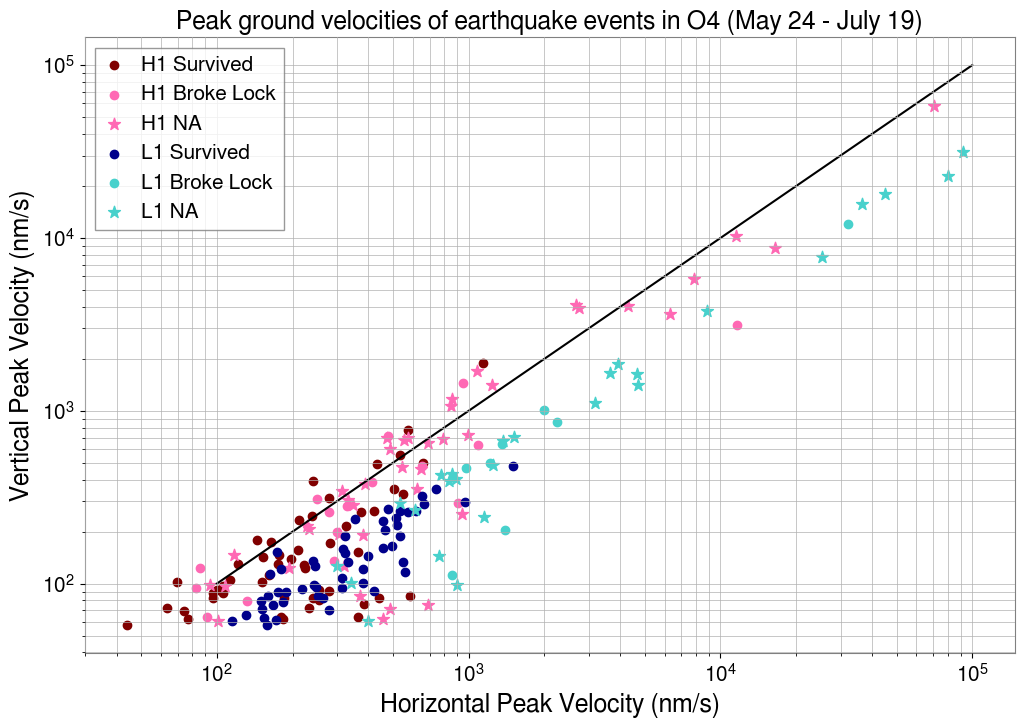

In [428]:
#plot magnitude of vertical vs. horizontal ground velocities
plt.figure(figsize=(12,8))
plt.title('Peak ground velocities of earthquake events in O4 (May 24 - July 19)', fontsize=18)

#plot survived and lostlock earthquake events
plt.scatter(Hdata[Hdata['Broke Lock']=='No']['Horiz. Vel.'], Hdata[Hdata['Broke Lock']=='No']['Vert. Vel.'],label='H1 Survived',color='maroon')
plt.scatter(Hdata[Hdata['Broke Lock']=='Yes']['Horiz. Vel.'], Hdata[Hdata['Broke Lock']=='Yes']['Vert. Vel.'],label='H1 Broke Lock',color='hotpink')
plt.scatter(Hdata[pd.isna(Hdata['Broke Lock'])==True]['Horiz. Vel.'], Hdata[pd.isna(Hdata['Broke Lock'])==True]['Vert. Vel.'],label='H1 NA',color='hotpink',s=80,marker='*')

plt.scatter(Ldata[Ldata['Broke Lock']=='No']['Horiz. Vel.'], Ldata[Ldata['Broke Lock']=='No']['Vert. Vel.'],label='L1 Survived',color='darkblue')
plt.scatter(Ldata[Ldata['Broke Lock']=='Yes']['Horiz. Vel.'], Ldata[Ldata['Broke Lock']=='Yes']['Vert. Vel.'],label='L1 Broke Lock',color='mediumturquoise')
plt.scatter(Ldata[pd.isna(Ldata['Broke Lock'])==True]['Horiz. Vel.'], Ldata[pd.isna(Ldata['Broke Lock'])==True]['Vert. Vel.'],label='L1 NA',color='mediumturquoise',s=80,marker='*')

plt.plot([100,100000], [100, 100000], '-', color='black') #plot y=x to easily visualize how vert. and horiz. compare

plt.xlabel('Horizontal Peak Velocity (nm/s)', fontsize=18)
plt.ylabel('Vertical Peak Velocity (nm/s)',fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-")

plt.savefig(vel_plotname)
plt.show()

In [446]:
#total probability of survival
len(Hdata[pd.isna(Hdata['Broke Lock'])==True])

41

In [426]:
#set bins #choose your own parameters 
#bins = np.logspace(1.7, 4.1, num=4)
bins = [50, 300, 1000, 20000]

In [427]:
#calculate probability of survival
Hsurvivedeq = Hdata[Hdata['Broke Lock']=='No']['Vert. Vel.'].value_counts(sort = False, bins = bins) #number of survived EQs
Htotaleq = Hdata['Vert. Vel.'].value_counts(sort = False, bins = bins) #total number of EQs
Hprob = Hsurvivedeq/Htotaleq

Lsurvivedeq = Ldata[Ldata['Broke Lock']=='No']['Vert. Vel.'].value_counts(sort = False, bins = bins) #number of survived EQs
Ltotaleq = Ldata['Vert. Vel.'].value_counts(sort = False, bins = bins) #total number of EQs
Lprob = Lsurvivedeq/Ltotaleq

print(Htotaleq)
print(Ltotaleq)

Vert. Vel.
(49.999, 300.0]      67
(300.0, 1000.0]      26
(1000.0, 20000.0]    14
Name: count, dtype: int64
Vert. Vel.
(49.999, 300.0]      59
(300.0, 1000.0]      14
(1000.0, 20000.0]    11
Name: count, dtype: int64


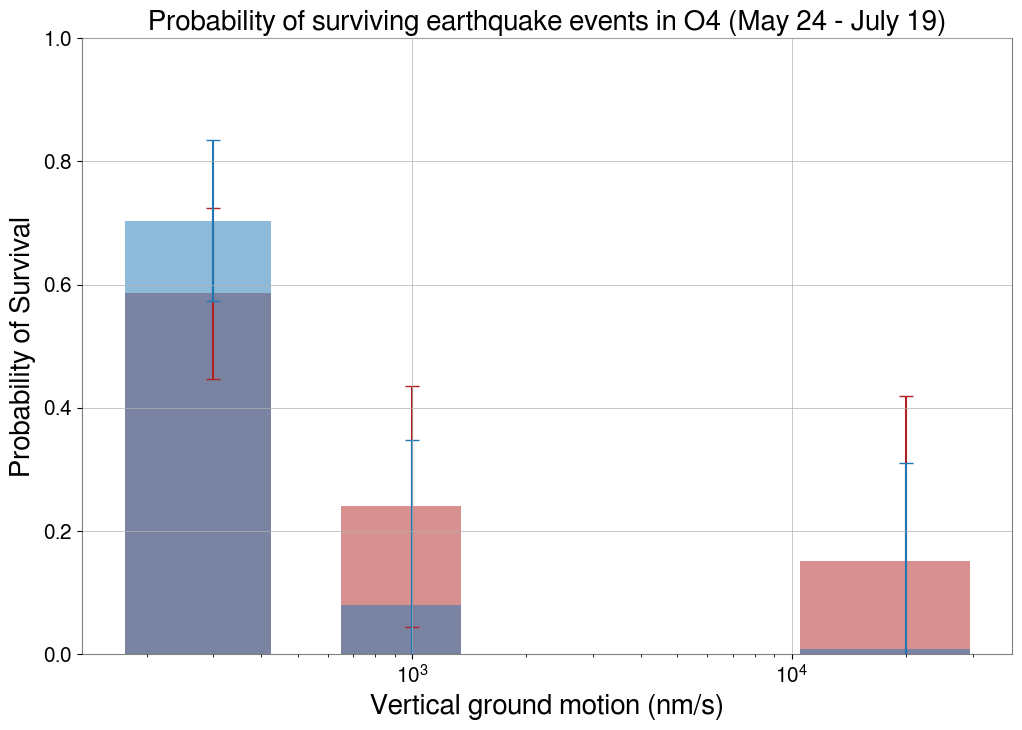

In [33]:
#plot histogram
dimw = np.diff(bins)
fig, ax = plt.subplots(figsize=(12,8))

H_x = bins[0:-1]
H_y = Hprob
H_yerr = 1/np.sqrt(Htotaleq.array)
H_b = ax.bar(H_x + dimw, H_y+0.01, dimw, bottom=-0.001, yerr=H_yerr, ls='none', 
             color='firebrick', alpha=0.5, error_kw=dict(ecolor='firebrick', capsize=5))

L_x = bins[0:-1]
L_y = Lprob
L_yerr = 1/np.sqrt(Ltotaleq.array)
L_b = ax.bar(L_x + dimw, L_y+0.01, dimw, bottom=-0.001, yerr=L_yerr, ls='none', 
             alpha=0.5, error_kw=dict(ecolor='tab:blue', capsize=5))

#ax.set_xticks(x + dimw / 2, labels=map(str, x))
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.set_xlabel('Vertical ground motion (nm/s)', fontsize=20)
ax.set_ylabel('Probability of Survival', fontsize=20)
ax.set_title('Probability of surviving earthquake events in O4 (May 24 - July 19)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(prob_plotname)
plt.show()

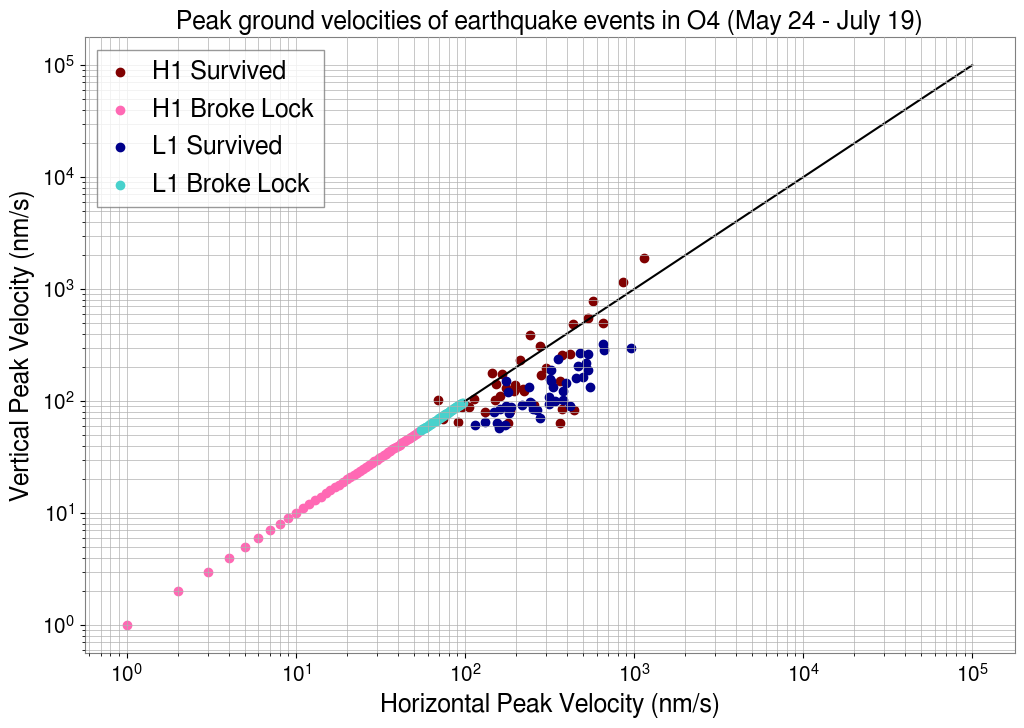

In [34]:
#plot magnitude of vertical vs. horizontal ground velocities
plt.figure(figsize=(12,8))
plt.title('Peak ground velocities of earthquake events in O4 (May 24 - July 19)', fontsize=18)

#plot survived and lostlock earthquake events
plt.scatter(Hdata[Hdata['Broke Lock']=='No']['Horiz. Vel.'], Hdata[Hdata['Broke Lock']=='No']['Vert. Vel.'],label='H1 Survived', color='maroon')
plt.scatter(Hdata[Hdata['Broke Lock']=='Yes']['LL Horiz. Vel.'], Hdata[Hdata['Broke Lock']=='Yes']['LL Vert. Vel.'],label='H1 Broke Lock', color='hotpink')
plt.scatter(Ldata[Ldata['Broke Lock']=='No']['Horiz. Vel.'], Ldata[Ldata['Broke Lock']=='No']['Vert. Vel.'],label='L1 Survived', color='darkblue')
plt.scatter(Ldata[Ldata['Broke Lock']=='Yes']['LL Horiz. Vel.'], Ldata[Ldata['Broke Lock']=='Yes']['LL Vert. Vel.'],label='L1 Broke Lock', color='mediumturquoise')
plt.plot([100,100000], [100, 100000], '-', color='black') #plot y=x to easily visualize how vert. and horiz. compare

plt.xlabel('Horizontal Peak Velocity (nm/s)', fontsize=18)
plt.ylabel('Vertical Peak Velocity (nm/s)',fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-")

plt.savefig(vel_plotname)
plt.show()

In [ ]:
#list of GPS times of all earthquake peaks
eqtimes = totaldf['Time of Peak'].tolist()

#times of earthquake events that break lock ("lockloss times")
ll_times = totaldf[totaldf['Broke Lock']=='Yes']['Time of Peak'].tolist()

In [42]:
l1df = pd.read_csv('L1_eqlockdf_may24jul19_30M_100M.csv')

In [47]:
l1df[l1df['Broke Lock']=='No'].sort_values(by=['Vert. Vel.'],ascending=False)

,Unnamed: 0,Date,Broke Lock,Time of Peak,Vert. Vel.,Horiz. Vel.,Ratio V/H,Time of Lock Loss,LL Vert. Vel.,LL Horiz. Vel.
69,69,2023-07-10 00:59:00,No,1.372986e+09,482.084300,1506.932026,0.319911,-,-,-
56,56,2023-07-01 11:02:00,No,1.372245e+09,354.547150,741.162659,0.478366,-,-,-
32,32,2023-06-16 12:54:00,No,1.370955e+09,321.758450,653.026366,0.492719,-,-,-
7,7,2023-05-31 03:25:00,No,1.369539e+09,295.658780,963.506792,0.306857,-,-,-
66,66,2023-07-08 23:05:00,No,1.372893e+09,287.728000,663.070948,0.433932,-,-,-
20,20,2023-06-09 22:30:00,No,1.370385e+09,270.692400,480.215593,0.563689,-,-,-
45,45,2023-06-20 11:19:00,No,1.371295e+09,264.483280,531.966744,0.497180,-,-,-
50,50,2023-06-23 20:46:00,No,1.371588e+09,262.373500,616.652862,0.425480,-,-,-
35,35,2023-06-17 06:15:00,No,1.371018e+09,261.257800,576.653828,0.453058,-,-,-
21,21,2023-06-10 10:10:00,No,1.370427e+09,240.617650,512.414317,0.469576,-,-,-
